<a href="https://colab.research.google.com/github/sancholp/movie_tagging/blob/main/movie_synopsis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tagging a movie based on its plot synopsis

In this project, I intend to create a model which, when fed a synopsis of a movie's plot, will assign it tags, as done on [IMDb](https://www.imdb.com/).

For this purpose, I will be using a dataset of ~6000 movie summaries, with assigned tags to them. These tags are mutually exclusive, leading to a multi-label classification problem.

### Importing necessary libraries and loading in dataset

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

In [157]:
raw_data = pd.read_csv("movie_plots.csv", sep=',', header=0, usecols=[2,3])

In [158]:
raw_data

,tags,plot
0,['documentary'],A stationary camera looks across the boulevard...
1,"['pirates', 'scifi']",Undersea adventures in a submarine by a dreami...
2,['drama'],The Outwitting of an Andalusian Brigand by a P...
3,['drama'],Before the storm. Epoch-making days. Liberty s...
4,['drama'],John and Tom Wilkins are brothers and most div...
...,...,...
5590,"['politics', 'biopic']","November 22, 1963. President John F. Kennedy h..."
5591,['super_hero'],"Melvin, a reluctant Superhero, lives only for ..."
5592,['musical'],"One dark night, at water's edge, a family of m..."
5593,"['politics', 'comedy']","Three minutes in to her set, Amy Schumer claim..."


In [159]:
# Replacing tags:String to tags:List[String]
list_tags = []
for tag in raw_data["tags"]:
    tag = ast.literal_eval(tag)
    list_tags.append(tag)

raw_data["tags"] = list_tags
raw_data

,tags,plot
0,[documentary],A stationary camera looks across the boulevard...
1,"[pirates, scifi]",Undersea adventures in a submarine by a dreami...
2,[drama],The Outwitting of an Andalusian Brigand by a P...
3,[drama],Before the storm. Epoch-making days. Liberty s...
4,[drama],John and Tom Wilkins are brothers and most div...
...,...,...
5590,"[politics, biopic]","November 22, 1963. President John F. Kennedy h..."
5591,[super_hero],"Melvin, a reluctant Superhero, lives only for ..."
5592,[musical],"One dark night, at water's edge, a family of m..."
5593,"[politics, comedy]","Three minutes in to her set, Amy Schumer claim..."


## Data Exploration

Before starting to train models, we should explore the dataset to see what insights we can obtain. Firstly, we'll look at the distribution of the tags assigned to each movie.

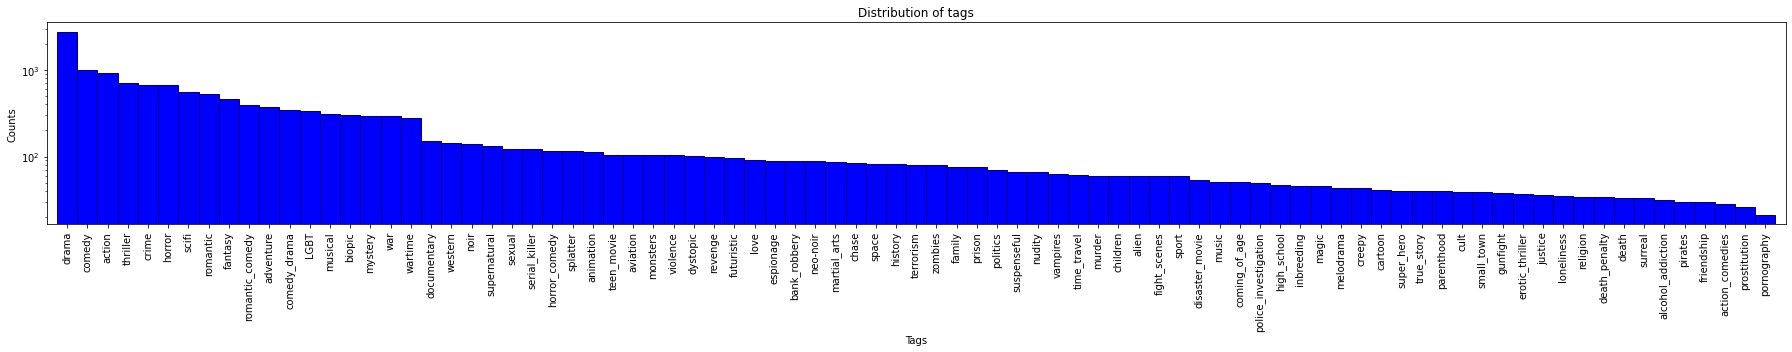

In [160]:
# Get total counts of each tag
tag_counts = pd.DataFrame({'tags': pd.Series([tag for tags in raw_data["tags"] for tag in tags])}).apply(pd.value_counts) 

# Plot tag distribution
tag_names = tag_counts.index.values.tolist()
tag_counts = tag_counts.values[:,0].tolist()

fig = plt.figure(figsize=(25,5))
plt.title('Distribution of tags')
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.xlim([-1, len(tag_names)])
plt.bar(tag_names, tag_counts, width=1, color='b', edgecolor='navy')
plt.yscale('log')
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

As we can see from the distribution of the tags, the dataset is quite unbalanced and shows a long tail. The difference between the most and least common tag is of almost 1.5 orders of magnitude. We should keep this in mind when training and evaluating our models, as simply predicting drama would artificially create a decent classifier.

In [90]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
encoded_tags = mlb.fit_transform(raw_data["tags"])
encoded_tags.shape

(5595, 85)

In [88]:
encoded_data = raw_data
encoded_data["encoded_tags"] = encoded_tags
encoded_data

ValueError: ignored

In [51]:
X, y = raw_data["plot"], raw_data["tags"]
print(X.shape, y.shape)

(5595,) (5595,)


### Encode the labels
A multilabel encoder is needed

In [72]:
print(mlb.classes_)
len(mlb.classes_)

['LGBT' 'action' 'action_comedies' 'adventure' 'alcohol_addiction' 'alien'
 'animation' 'aviation' 'bank_robbery' 'biopic' 'cartoon' 'chase'
 'children' 'comedy' 'comedy_drama' 'coming_of_age' 'creepy' 'crime'
 'cult' 'death' 'death_penalty' 'disaster_movie' 'documentary' 'drama'
 'dystopic' 'erotic_thriller' 'espionage' 'family' 'fantasy'
 'fight_scenes' 'friendship' 'futuristic' 'gunfight' 'high_school'
 'history' 'horror' 'horror_comedy' 'inbreeding' 'justice' 'loneliness'
 'love' 'magic' 'martial_arts' 'melodrama' 'monsters' 'murder' 'music'
 'musical' 'mystery' 'neo-noir' 'noir' 'nudity' 'parenthood' 'pirates'
 'police_investigation' 'politics' 'pornography' 'prison' 'prostitution'
 'religion' 'revenge' 'romantic' 'romantic_comedy' 'scifi' 'serial_killer'
 'sexual' 'small_town' 'space' 'splatter' 'sport' 'super_hero'
 'supernatural' 'surreal' 'suspenseful' 'teen_movie' 'terrorism'
 'thriller' 'time_travel' 'true_story' 'vampires' 'violence' 'war'
 'wartime' 'western' 'zombies']


85